In [1]:
import sys
sys.path.append("/work/multi_doc_analyzer")
sys.path.append("/work/relation_extraction/Bert_model/baseline/data/")

import torch as T
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.cuda
from allennlp.nn import util as nn_util
from multi_doc_analyzer.structure.structure import *
from multi_doc_analyzer.tokenization.tokenizer import MDATokenizer
from tqdm import tqdm

from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.tokenizers import Token
from allennlp.data.token_indexers import TokenIndexer

from allennlp.data.instance import Instance
from allennlp.data.fields import TextField, LabelField, ArrayField

from ace05_set_reader import ACE05Reader

from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BucketIterator, DataIterator, BasicIterator
from allennlp.nn.util import get_text_field_mask
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder
import random

from allennlp.data.token_indexers import PretrainedBertIndexer
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders.bert_token_embedder import PretrainedBertEmbedder

from sklearn.metrics import precision_recall_fscore_support as prs
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import csv

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
train_path = "/work/LDC2006T06/dataset/train/"
test_path = "/work/LDC2006T06/dataset/test/"
model_folder = "/work/model_checkpoint/bert_model_checkpoint/bert_modify_seq/"
output_path = "/work/relation_extraction/Bert_model/bert_modify_seq/analysis/"

In [3]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    seed=1,
    batch_size=64,
    lr=3e-4,                # learning rate
    epochs=25,
    mlp_hidden_sz=300,
    lstm_hidden_sz=768,
    arg_sz=20,              # position embedding size
    max_seq_len=100
)

In [4]:
USE_GPU = T.cuda.is_available()
USE_GPU

True

In [5]:
# set seed for both CPU and CUDA
T.manual_seed(config.seed)

In [6]:
e_type2idx = {'X':0, 'O': 1, 'PER': 2, 'ORG': 3, 'LOC': 4, 'GPE': 5, 'FAC': 6, 'VEH': 7, 'WEA': 8}

r_label2idx = {'PHYS-lr': 1, 'PART-WHOLE-lr': 2, 'PER-SOC-lr': 3, 'ORG-AFF-lr': 4, 'ART-lr': 5, 'GEN-AFF-lr': 6,
               'PHYS-rl': 7, 'PART-WHOLE-rl': 8, 'PER-SOC-rl': 9, 'ORG-AFF-rl': 10, 'ART-rl': 11, 'GEN-AFF-rl': 12,
               'NONE': 0}

# r_label2idx = {'PHYS': 1, 'PART-WHOLE': 2, 'PER-SOC': 3, 'ORG-AFF': 4, 'ART': 5, 'GEN-AFF': 6, 'NONE': 0}

r_idx2label = {v: k for k, v in r_label2idx.items()}

class RelationDatasetReader(DatasetReader):
    """
    Reads Structure object formatted datasets files, and creates AllenNLP instances.
    """
    def __init__(self, token_indexers: Dict[str, TokenIndexer]=None, 
                 MAX_WORDPIECES: int=config.max_seq_len, 
                 is_training = False, ace05_reader: ACE05Reader=None):
        # make sure results may be reproduced when sampling...
        super().__init__(lazy=False)
        random.seed(0)
        self.is_training = is_training
        self.ace05_reader = ace05_reader
        
        # NOTE AllenNLP automatically adds [CLS] and [SEP] word peices in the begining and end of the context,
        # therefore we need to subtract 2
        self.MAX_WORDPIECES = MAX_WORDPIECES - 2
        
        # BERT specific init
        self._token_indexers = token_indexers

    def text_to_instance(self, sentence: Sentence) -> Instance:

        e_tuple_check_dicts = {} # {(train_arg_l.id, train_arg_r.id):true_label, ...}
        if self.is_training: 
            for r in sentence.relation_mentions:
                train_arg_l, train_arg_r, true_label = r.get_left_right_args()
                e_tuple_check_dicts[(train_arg_l.id, train_arg_r.id)] = true_label

        # construct pair entities
        for arg1_idx in range(len(sentence.entity_mentions)-1):
            for arg2_idx in range(arg1_idx+1, len(sentence.entity_mentions)):
                field = {}
                sentence_tokens = []
    
                arg1 = sentence.entity_mentions[arg1_idx]
                arg2 = sentence.entity_mentions[arg2_idx]
                
                # dicide which is on the left and redefine
                if arg1.char_b >= arg2.char_b:
                    entity_l = arg2
                    entity_r = arg1
                else:
                    entity_l = arg1
                    entity_r = arg2                    
                
                # in order to save our two entities which may be splited
                ent = [[] for i in range(2)]             # index 0 : 0 for ent_l, 1 for ent_r
                
                # create our manual form of seq
                for i,t in enumerate(sentence.tokens):
                    if i >= entity_l.token_b and i < entity_l.token_e:
                        ent[0].append(t.text)
                        sentence_tokens.append(Token(text="[unused" + str(e_type2idx[entity_l.type]) + "]"))
                    elif i >= entity_r.token_b and i < entity_r.token_e:
                        ent[1].append(t.text)
                        sentence_tokens.append(Token(text="[unused" + str(e_type2idx[entity_r.type]) + "]"))
                    else:
                        sentence_tokens.append(Token(text=t.text))
                sentence_tokens.append(Token(text="[SEP]"))
                for i in range(len(ent[0])):
                    sentence_tokens.append(Token(text=ent[0][i]))
                sentence_tokens.append(Token(text="[SEP]"))
                for i in range(len(ent[1])):
                    sentence_tokens.append(Token(text=ent[1][i]))
                
                sentence_field = TextField(sentence_tokens, self._token_indexers)
                fields = {"tokens": sentence_field}

                arg_vec = T.tensor([[0, 0] for i in range(len(sentence.tokens) + 2)], dtype=T.long)   # long type to feed into embedding layer
                
                # +1 because the first token is [CLS]
                pos = lambda t, b, e: 0 if t >= b and t < e else ( (t-b) if t < b else (t-e+1) ) 
                for i in range(len(sentence.tokens) + 2):
                    arg_vec[i][0] = pos(i-1, entity_l.token_b, entity_l.token_e) + config.max_seq_len    # arg_l position, i-1 for [CLS]
                    arg_vec[i][1] = pos(i-1, entity_r.token_b, entity_r.token_e) + config.max_seq_len    # arg_r position, i-1 for [CLS]
                fields["arg_idx"] = ArrayField(arg_vec)
    
                # relation
                if self.is_training:
                    if (arg1.id, arg2.id) in e_tuple_check_dicts.keys():
                        fields["label"] = LabelField(r_label2idx[e_tuple_check_dicts[(arg1.id, arg2.id)]], skip_indexing=True)
                    else:
                        fields["label"] = LabelField(r_label2idx['NONE'], skip_indexing=True)
                yield Instance(fields)
    
    def _read(self, file_path: str)->Iterator: 
        doc_dicts = self.ace05_reader.read(file_path)
        tokenizer = MDATokenizer('bert-en')
        for doc in doc_dicts.values():
            tokenizer.annotate_document(doc)
            for s in doc.sentences: 
                if len(s.tokens) <= config.max_seq_len - 2:
                    for instance in self.text_to_instance(s):
                        yield instance

In [7]:
# ace05_reader = ACE05Reader(lang='en')

# token_indexer = PretrainedBertIndexer(
#     pretrained_model="bert-base-uncased",
# #         max_pieces=config.max_seq_len,
# #         do_lowercase=False               # for cased condition
# )

# # AllenNLP DatasetReader
# reader = RelationDatasetReader(
#     is_training=True, 
#     ace05_reader=ace05_reader, 
#     tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
#     token_indexers={"tokens": token_indexer}
# )

# train_ds = reader.read(train_path)

In [8]:
class BERT(Model):
    def __init__(self, word_embeddings: TextFieldEmbedder,
                out_sz: int=len(r_label2idx)):
        super().__init__(vocab)
        self.word_embeddings = word_embeddings
        self._position_embeddings = T.nn.Embedding(num_embeddings=(config.max_seq_len)*2, embedding_dim=config.arg_sz, padding_idx=0)
        
        # bert output is of dimension 768
        self.lstm = T.nn.LSTM(input_size=768 + 2*config.arg_sz, hidden_size=768, batch_first=True, bidirectional=True)
        self.projection1 = nn.Linear(config.lstm_hidden_sz * 2, config.mlp_hidden_sz)
        self.projection2 = nn.Linear(config.mlp_hidden_sz, out_sz)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, tokens: Dict[str, T.tensor], arg_idx: T.tensor, label: T.tensor = None) -> Dict[str, T.tensor]:
        mask = get_text_field_mask(tokens)
#         print(tokens)
#         print(arg_idx.shape)
        embeddings = self.word_embeddings(tokens)
#         print(embeddings.shape)
        arg_idx = arg_idx.type(T.long)
        
#         cut_len = 0
#         for i in range(len(arg_idx)):
#             for j in range(len(arg_idx[i])-1, -1, -1):
#                 if arg_idx[i][j][0] != config.max_seq_len-1 or arg_idx[i][j][1] != config.max_seq_len-1:
#                     pad_len = j+1
# #                     print(pad_len, arg_idx[i][j][0], arg_idx[i][j][1])
#                     break
#             if pad_len > cut_len:
#                 cut_len = pad_len

#         print(cut_len)
        cut_len = max(len(arg_idx[i]) for i in range(len(arg_idx)))    # for epoch = 1
        
        embeddings = embeddings[:,:cut_len,:]
#         arg_idx = arg_idx[:,:cut_len,:]
#         print(arg_idx)
#         print(embeddings.shape)
        arg_emb = self._position_embeddings(arg_idx)
        arg_cat = T.cat((arg_emb[:,:,0,:], arg_emb[:,:,1,:]), -1)
#         print(arg_emb)
#         print(arg_cat)
        concat = T.cat((embeddings, arg_cat), -1)
#         print(concat)
        ot, hs = self.lstm(concat)
        
        mlp_hs = self.projection1(ot[:, -1, :])
#         print(mlp_hs)
        class_logits = self.projection2(mlp_hs)
#         print(label)
        output = {"class_logits": class_logits}
        output["loss"] = self.loss(class_logits, label)

        return output

In [9]:
from scipy.special import expit # the sigmoid function
def tonp(tsr): return tsr.detach().cpu().numpy()

In [10]:
# Predict
class Predictor:
    def __init__(self, model: Model, iterator: DataIterator,
                 cuda_device: int=-1) -> None:
        self.model = model
        self.iterator = iterator
        self.cuda_device = cuda_device
        
    def _extract_data(self, batch) -> np.ndarray:
        out_dict = self.model(**batch)
        return expit(tonp(out_dict["class_logits"]))
    
    def predict(self, ds: Iterable[Instance]) -> np.ndarray:
        pred_generator = self.iterator(ds, num_epochs=1, shuffle=False)
        self.model.eval()
        pred_generator_tqdm = tqdm(pred_generator, total=self.iterator.get_num_batches(ds))
        preds = []
        with T.no_grad():
            for batch in pred_generator_tqdm:
                batch = nn_util.move_to_device(batch, self.cuda_device)
                preds.append(self._extract_data(batch))
        return np.concatenate(preds, axis=0)

In [11]:
def plot_comfusion_matrix(label_classes, predict_classes, out_folder, file_name):
    label_types = list(r_idx2label.values())

    cm = confusion_matrix(label_classes, predict_classes, label_types)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color='white')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + label_types)
    ax.set_yticklabels([''] + label_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig(out_folder + 'confusion_matrix_' + file_name + '.png')
    plt.show()
    
    # remove the data which is none or predict none
    
    pre, recall, f1, sup = prs(label_classes, predict_classes, average='macro')
    
    print("Accuracy:", sum(cm[i][i] for i in range(len(cm))) / len(label_classes))
    print("Precision:", pre)
    print("Recall:", recall)
    print("F1 score:", f1)

In [12]:
def err_analyze(ds, true, pred, opt):
    
    # classify different kinds of error
    detail = [[[] for j in range(len(r_label2idx))] for i in range(len(r_label2idx))]
    for i in range(len(ds)):
         if true[i] != pred[i]:
            detail[r_label2idx[true[i]]][r_label2idx[pred[i]]].append(i)
    
    # print into a csv file
    with open(output_path + "error_detail_" + opt + ".csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Sentence", "Two_Entity", "Predict", "Label", "idx"])
        for j in range(len(detail)):
            for k in range(len(detail)):
                with_element = 0
                if k == j:
                    continue
                for i in detail[j][k]:
                    with_element = 1
                    ent1 = []
                    ent2 = []
                    for g in range(len(vars(ds[i].fields['arg_idx'])['array'])):
                        if int(vars(ds[i].fields['arg_idx'])['array'][g][0]) == 100 or int(vars(ds[i].fields['arg_idx'])['array'][g][1]) == 100:
                            if int(vars(ds[i].fields['arg_idx'])['array'][g][0]) == 100:
                                ent1.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
                            else:
                                ent2.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
    
                    tostr = lambda a: [str(a[i]) for i in range(len(a))] 
                    writer.writerow([" ".join(tostr(vars(ds[i].fields['tokens'])['tokens'])), [ent1, ent2], pred[i], true[i], i])
                if with_element == 1:
                    writer.writerow("")

In [13]:

if __name__ == '__main__':

    ace05_reader = ACE05Reader(lang='en')
    
    token_indexer = PretrainedBertIndexer(
        pretrained_model="bert-base-uncased",
#         do_lowercase=False               # for cased condition
    )
 
	# AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        ace05_reader=ace05_reader, 
        token_indexers={"tokens": token_indexer}
    )

    train_ds = reader.read(train_path)
    print(len(train_ds))
#     for e in range(20):
#         print(len(vars(train_ds[e].fields['tokens'])['tokens']))
#         print(vars(train_ds[e].fields['tokens']))
#         print(len(vars(train_ds[0].fields['arg_idx'])['array']))
#         print(vars(train_ds[e].fields['arg_idx']))
#         print(vars(train_ds[e].fields['label']))
    
    # user-defined new label
#     new_token = {"bert-pretrained": ["[" + i +"]" for i in e_type2idx.keys()]}
#     print(type(new_token["tokens"]))
#     vocab = Vocabulary(tokens_to_add=new_token)
    vocab = Vocabulary()
#     print(vocab.get_index_to_token_vocabulary(namespace="token"))
#     print(type(vocab))
    iterator = BucketIterator(batch_size=config.batch_size, sorting_keys=[("tokens", "num_tokens")])
    iterator.index_with(vocab)

    bert_embedder = PretrainedBertEmbedder(
        pretrained_model="bert-base-uncased",
        top_layer_only=True, # conserve memory   
    )
    
#     bert_embedder.vocab={"[per]":500000 , "[org]": 60000000}
    
    word_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": bert_embedder},
                                                                # we'll be ignoring masks so we'll need to set this to True
                                                               allow_unmatched_keys = True)
#     print(vocab.by_name("default"))
#     print(token_indexer.tokens_to_indices([Token(text="[unused100]")], vocab, "test"))
#     print(vocab.get_index_to_token_vocabulary(namespace="bert"))
    model = BERT(word_embeddings)
    if USE_GPU:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=config.lr)

0it [00:00, ?it/s]
 96%|█████████▋| 338/351 [00:02<00:00, 121.03it/s]
2187it [00:25, 65.11it/s][00:03<00:00, 116.77it/s]

ORG-AFF
FBI
FBI
error! relation argument positions error!
ORG-AFF
Department
Department
error! relation argument positions error!
ORG-AFF
CIA
CIA
error! relation argument positions error!


65310it [01:47, 608.19it/s] 


65310


In [14]:
    # training
    from allennlp.training.trainer import Trainer

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        iterator=iterator,
        train_dataset=train_ds,
        cuda_device=0 if USE_GPU else -1,
        num_epochs=config.epochs,
    )

In [15]:
    # train the model 
    metrics = trainer.train()

loss: 0.2833 ||: 100%|██████████| 1021/1021 [02:29<00:00,  6.86it/s]
loss: 0.2010 ||: 100%|██████████| 1021/1021 [02:13<00:00,  6.62it/s]
loss: 0.1653 ||: 100%|██████████| 1021/1021 [02:15<00:00,  8.81it/s]
loss: 0.1425 ||: 100%|██████████| 1021/1021 [02:14<00:00,  7.79it/s]
loss: 0.1223 ||: 100%|██████████| 1021/1021 [02:15<00:00,  7.82it/s]
loss: 0.1022 ||: 100%|██████████| 1021/1021 [02:14<00:00,  8.25it/s]
loss: 0.0844 ||: 100%|██████████| 1021/1021 [02:14<00:00,  9.03it/s]
loss: 0.0669 ||: 100%|██████████| 1021/1021 [02:14<00:00,  8.01it/s]
loss: 0.0534 ||: 100%|██████████| 1021/1021 [02:14<00:00,  7.59it/s]
loss: 0.0418 ||: 100%|██████████| 1021/1021 [02:15<00:00,  8.33it/s]
loss: 0.0364 ||: 100%|██████████| 1021/1021 [02:14<00:00,  5.98it/s]
loss: 0.0260 ||: 100%|██████████| 1021/1021 [02:14<00:00,  9.58it/s]
loss: 0.0253 ||: 100%|██████████| 1021/1021 [02:14<00:00,  7.60it/s]
loss: 0.0214 ||: 100%|██████████| 1021/1021 [02:17<00:00,  7.17it/s]
loss: 0.0194 ||: 100%|██████████| 

In [16]:
    # load model
#     model.load_state_dict(T.load(model_folder + "model.th"))

In [17]:
    # save 
    with open(model_folder+'model.th', 'wb') as f:
        T.save(model.state_dict(), f)

In [18]:
    # training data analysis
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    train_preds = predictor.predict(train_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in train_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(train_preds, axis=-1)]
    err_analyze(train_ds, label_types, predict_types, "train")

100%|██████████| 1021/1021 [02:06<00:00,  8.07it/s]


[[  575     2     0     1     0     0     1     1     0     0     0     0
     42]
 [    2   261     0     1     0     1     0     1     0     0     0     0
      1]
 [    0     0   235     1     0     0     0     0     0     2     0     1
     21]
 [    1     4     0   310     0     1     0     0     0     2     0     0
     32]
 [    0     0     0     0   228     0     0     1     0     0     0     0
     34]
 [    2    15     0     0     0   108     0     0     0     0     0     0
      9]
 [    0     0     0     0     0     0   104     0     0     0     1     0
      3]
 [    0     1     0     0     1     1     0   208     0     0     0     0
     14]
 [    0     0     7     0     1     0     0     0    11     0     0     0
      2]
 [    0     0     4     0     2     0     0     3     0   447     2     6
     70]
 [    0     0     0     0     0     0     1     0     0     0    42     0
      3]
 [    0     0     1     1     1     2     2     0     0     2     2   133
     32]
 [  

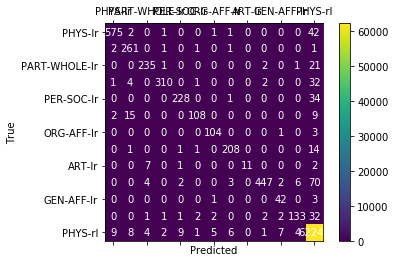

Accuracy: 0.9938753636502833
Precision: 0.940576506995012
Recall: 0.8677337069598476
F1 score: 0.8959082201368863


In [19]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "train_full")

In [20]:
    # testing data analysis
    
    # AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        ace05_reader=ace05_reader, 
        token_indexers={"tokens": token_indexer}
    )
    
    test_ds = reader.read(test_path)
    print(len(test_ds))
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    test_preds = predictor.predict(test_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in test_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(test_preds, axis=-1)]  
    
    err_analyze(test_ds, label_types, predict_types, "test")

0it [00:00, ?it/s]
 90%|█████████ | 72/80 [00:00<00:00, 167.72it/s]
13522it [00:29, 460.36it/s]00<00:00, 163.90it/s]
  0%|          | 0/212 [00:00<?, ?it/s]

13522


100%|██████████| 212/212 [00:29<00:00,  9.00it/s]


[[   26     2     0     1     0     0     0     0     0     0     0     0
    120]
 [    3    28     0     0     0     0     0     0     0     0     0     0
     31]
 [    0     0    13     0     0     0     0     0     0     1     0     0
     39]
 [    2     3     1     8     0     2     0     0     0     0     0     0
     45]
 [    0     0     0     0    12     0     0     2     0     0     0     0
     73]
 [    3     6     0     2     0     3     0     0     0     0     0     0
     14]
 [    0     0     0     0     0     0     5     0     0     0     0     0
     28]
 [    0     2     0     0     1     0     0     5     0     1     0     0
     45]
 [    0     0     1     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     1     0     3     1     0     4     0    30     0     1
    132]
 [    0     1     0     0     1     0     3     0     0     0     0     0
     13]
 [    0     0     0     0     0     0     0     2     0     1     0     7
     23]
 [  

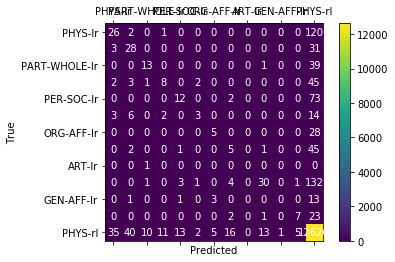

Accuracy: 0.9434255287679337
Precision: 0.38937457582536344
Recall: 0.22049522283784004
F1 score: 0.26238777574885236


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "test_full")